<a href="https://colab.research.google.com/github/kevinhe107/CAPSTONE_Bert/blob/main/FineTuning_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==1.4.0 torchvision==0.5.0
!pip install -q -U watermark
!pip install -qq transformers

     |████████████████████████████████| 753.4MB 23kB/s 
     |████████████████████████████████| 4.0MB 61.5MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
     |████████████████████████████████| 2.3MB 9.1MB/s 
     |████████████████████████████████| 3.3MB 60.0MB/s 
     |████████████████████████████████| 901kB 50.3MB/s 


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

* import data from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CAPSTONE/data/cleaned_headlines_untokinized_1300.csv')
df['Sentiment'].value_counts()

bullish    561
neutral    537
bearish    201
Name: Sentiment, dtype: int64

In [ ]:
df = df.drop('Ticker', axis = 1)

Numerical categorization of targets

In [ ]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: 2 if x =='bullish' else (1 if x == 'bearish' else 0))
class_names = ['bearish', 'neutral', 'bullish']

In [ ]:
df.head()

,News_Title,Sentiment
0,Applied Optoelectronics (AAOI) May Report Nega...,1
1,Applied Optoelectronics Announces Date of Firs...,0
2,Have Insiders Been Buying Applied Optoelectron...,2
3,Why Applied Optoelectronics Stock Tanked Today,1
4,Applied Optoelectronics Inc (AAOI) Q4 2020 Ear...,0


* Data tokenization using bert tokernizer PREPROCESSING

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
# test tokenization
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [ ]:
# special tokens
# [SEP]marker for ending of a sentence
tokenizer.sep_token, tokenizer.sep_token_id
#[CLS] add this token to the start of each sentence to let bert know we are doing classification
tokenizer.cls_token, tokenizer.cls_token_id
# [PAD] for padding
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
# built in function to tokenize in one method
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 32,
    add_special_tokens = True,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_token_type_ids = False,
    return_tensors ='pt'
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

* finding the fixed length (max length)

In [ ]:
tokens_lens = []

for txt in df["News_Title"]:
  tokens = tokenizer.encode(txt, max_length=512)
  tokens_lens.append(len(tokens))

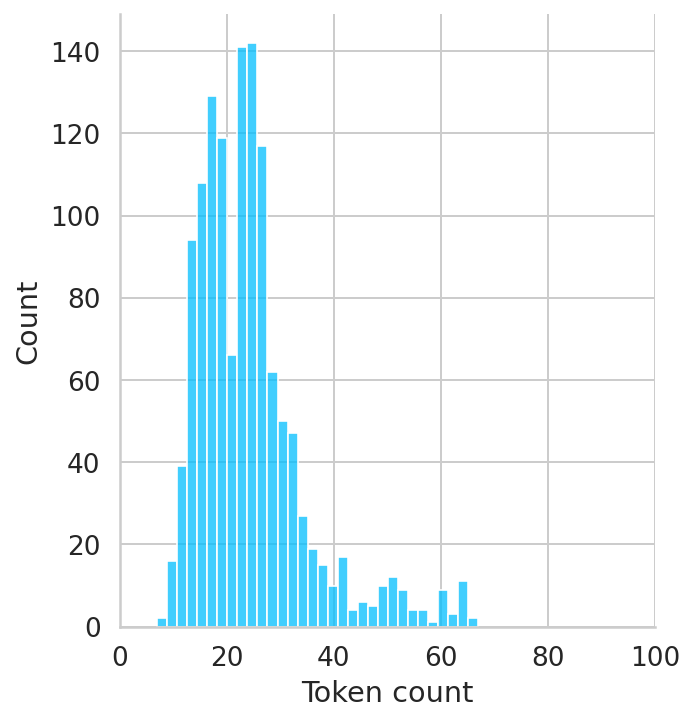

In [ ]:
sns.displot(tokens_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count');
# just do highest since i have the processing power with 65

* Class dataset

In [ ]:
class headlinesData(Dataset):
  def __init__(self, headlines, targets, tokenizer, max_len):
    self.headlines = headlines
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.headlines)

  def __getitem__(self, item):
    headlines = str(self.headlines[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      headlines,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    
    return {
        'review_text': headlines,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
      }

In [ ]:
MAX_LEN = 70
BATCH_SIZE = 8
EPOCHS = 20

In [ ]:
df_train, df_test = train_test_split(
    df,
    test_size =0.2,
    random_state = RANDOM_SEED
)

df_val, df_test = train_test_split(
    df_test,
    test_size = 0.5,
    random_state=RANDOM_SEED
)

df_train.shape, df_val.shape, df_test.shape

((1040, 2), (130, 2), (130, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = headlinesData(
      headlines = df.News_Title.to_numpy(),
      targets = df.Sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 4
  )

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE) 

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
encoding['input_ids']

tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids = encoding['input_ids'],
  attention_mask = encoding['attention_mask']
)

In [ ]:
bert_model.config.hidden_size

768

* building sentiment classifier

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p = 0.3)

    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)


In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([8, 70])
torch.Size([8, 70])


In [ ]:
model(input_ids, attention_mask)

tensor([[ 0.6320, -0.9349,  0.1905],
        [ 0.6349, -0.1975,  0.4514],
        [ 0.5951, -0.3335,  0.3957],
        [ 0.5289, -0.7985,  1.0192],
        [ 0.2653, -0.9855,  0.5543],
        [ 0.1888, -1.0395,  0.7178],
        [ 0.6037, -0.5211,  0.2219],
        [ 0.8153, -0.4334,  0.0677]], device='cuda:0', grad_fn=<AddmmBackward>)

* TRAINING

In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    
    _, preds = torch.max(outputs, dim = 1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0) #combats expanding gradient
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
          input_ids = input_ids,
          attention_mask = attention_mask
      )

      _, preds = torch.max(outputs, dim = 1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(train_acc)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------
Train loss 0.9943643900064322 accuracy 0.5125000000000001
Val   loss 0.8932278471834519 accuracy 0.6153846153846154

Epoch 2/20
----------
Train loss 0.6795382153529387 accuracy 0.7307692307692308
Val   loss 0.6540640662698185 accuracy 0.7769230769230769

Epoch 3/20
----------
Train loss 0.5271003079528992 accuracy 0.8211538461538462
Val   loss 0.5834886501817143 accuracy 0.8

Epoch 4/20
----------
Train loss 0.37710990051810556 accuracy 0.8913461538461539
Val   loss 0.5620814750299734 accuracy 0.8384615384615385

Epoch 5/20
----------
Train loss 0.2711189698714476 accuracy 0.9355769230769231
Val   loss 0.7871468908646527 accuracy 0.7923076923076924

Epoch 6/20
----------
Train loss 0.16520533957160435 accuracy 0.9567307692307693
Val   loss 0.8752221938441781 accuracy 0.8230769230769232

Epoch 7/20
----------
Train loss 0.10996428487392572 accuracy 0.9711538461538463
Val   loss 0.9853749376009492 accuracy 0.8230769230769232

Epoch 8/20
----------
Train loss 0.0881

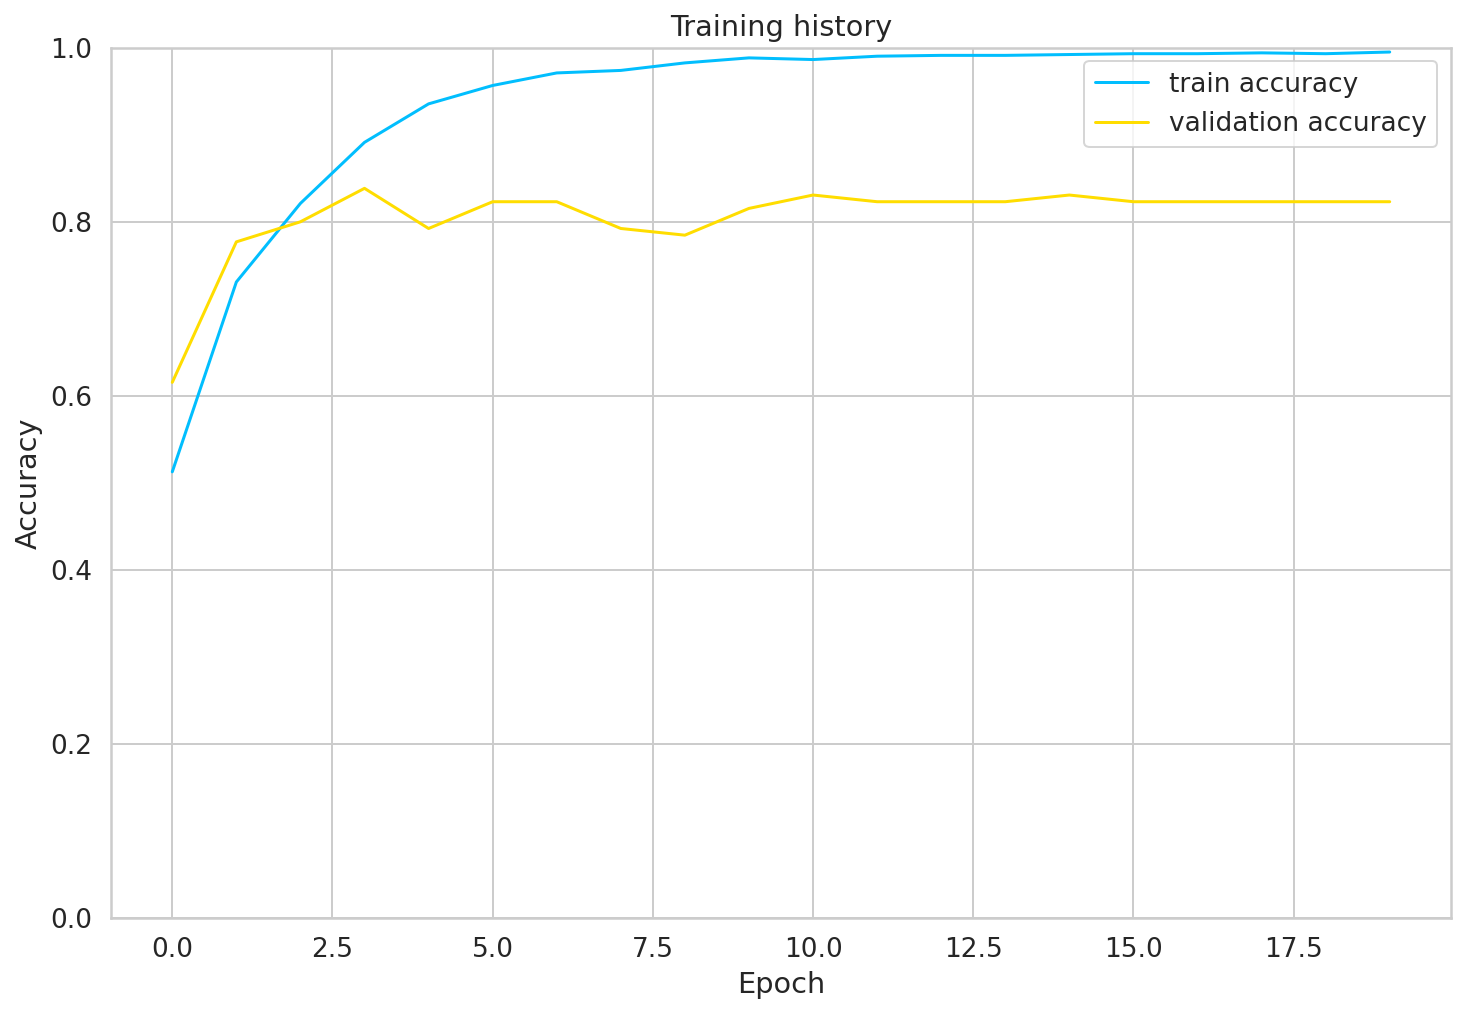

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

EVALUATION

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.8076923076923077

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  headlines_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d['review_text']
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(
          input_ids = input_ids,
          attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      headlines_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return headlines_texts, predictions, prediction_probs, real_values

In [ ]:
y_headlines_text, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     bearish       0.86      0.75      0.80        57
     neutral       0.60      0.80      0.69        15
     bullish       0.83      0.86      0.85        58

    accuracy                           0.81       130
   macro avg       0.76      0.81      0.78       130
weighted avg       0.82      0.81      0.81       130



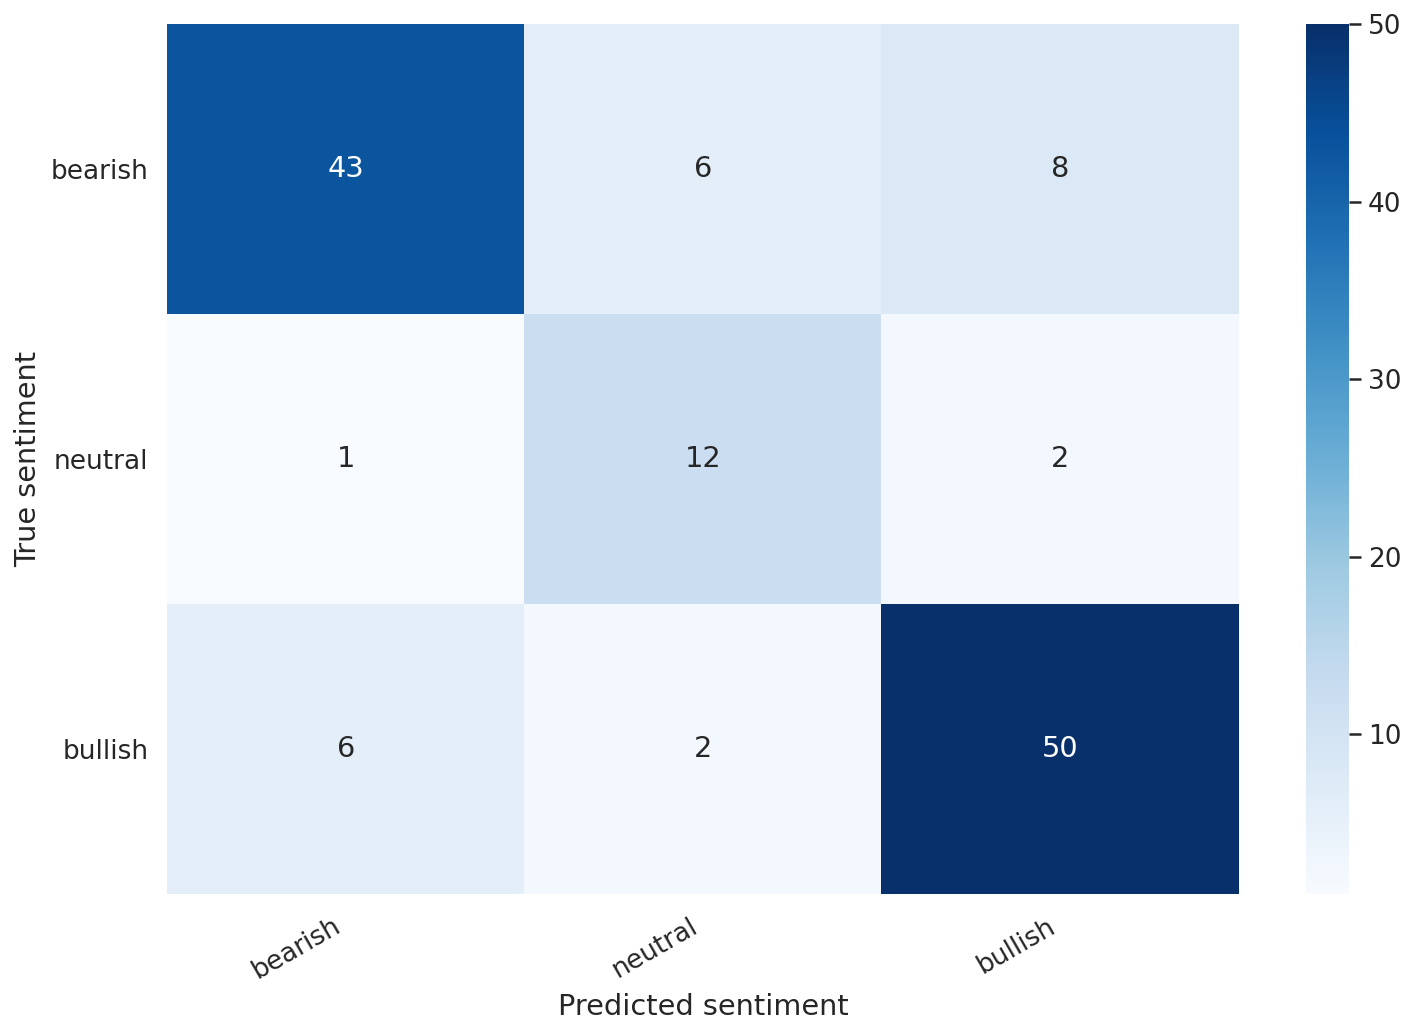

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

PREDICTION ON RANDOM INPUT

In [ ]:
headlines_text = 'Why Rosenblatt is Rooting for AAOI Stock Ahead of Earnings'

In [ ]:
encoded_review = tokenizer.encode_plus(
  headlines_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {headlines_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Why Rosenblatt is Rooting for AAOI Stock Ahead of Earnings
Sentiment  : bullish


Saving weights and export it

In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/CAPSTONE/headline_model_weights')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/CAPSTONE/headline_model_weights'))
#model.eval()

<All keys matched successfully>

Testing out a headline

In [ ]:
headlines_text = "Why Rosenblatt is Rooting for AAOI Stock Ahead of Earnings"

In [ ]:
encoded_review = tokenizer.encode_plus(
  headlines_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {headlines_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Why Rosenblatt is Rooting for AAOI Stock Ahead of Earnings
Sentiment  : bullish
